In [44]:
import cv2
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from scipy.ndimage.measurements import label

def draw_boxes(img, bboxes,color=(0,0,255),thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy,bbox[0],bbox[1],color,thick)
    return imcopy

def get_hog_features(img,orient,pix_per_cell,cells_per_block,vis=False,feature_vec=True):
    if vis == True:
        feature,hog_image = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell),
                               cells_per_block=(cells_per_block,cells_per_block),transform_sqrt=True,
                               visualise=vis,feature_vector=feature_vec)
        return feature,hog_image
    else:
        feature = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell),
                               cells_per_block=(cells_per_block,cells_per_block),transform_sqrt=True,
                               visualise=vis,feature_vector=feature_vec)
    
        return feature

def bin_spatial(img, size=(32,32)):
    features = cv2.resize(img,size).ravel()
    return features

def color_hist(img,nbins=32,bins_range=(0,256)):
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    return hist_features

def extract_features(image , color_space='YCrCb',spatial_size=(32,32),hist_bins=32,orient=9,pix_per_cell=8,cell_per_block=2,
                     hog_channel='ALL',spatial_feat=True,hist_feat=True,hog_feat=True):
    features = []
    if color_space !='RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
        
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image,size=spatial_size)
        features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image,nbins = hist_bins)
        features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],orient,pix_per_cell,cell_per_block,
                                                        vis = False,feature_vec = True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],orient,pix_per_cell,cell_per_block,
                                                vis = False,feature_vec=True )
            
        features.append(hog_features)
    return features

def extract_features_of_all_images(imgPath):
    features = []
    for file in imgPath:
        file_features = []
        image = mpimg.imread(file)
        image = image.astype(np.float32)/255
        imshape = image.shape
        #if(imshape[0] != 64 || imshape[1] != 64):
            #image = cv2.resize(image,(64,64,3))
        #print(image.shape)
        file_features = extract_features(image)
        features.append(np.concatenate(file_features))
    return features


    
def add_heat(heatmap,bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
    return heatmap

def apply_theshold(heatmap,threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeld_bboxes(img,labels):
    for car_number in range(1,labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)
    return img      
    
def find_cars(img, ystart,ystop,xstart,xstop,scale,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch =  cv2.cvtColor(img_tosearch,cv2.COLOR_RGB2YCrCb)
    plt.imshow(img_tosearch)
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    if scale != 1:
        impshape = img.shape
        ctrans_tosearch = cv2.resize(img_tosearch,(np.int(imshape[1]/scale),np.int(imshape[0]/scale)))
        
    nxblocks = (ch1.shape[1] //pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] //pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block **2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
  
    #feat = extract_features(img_tosearch)
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,feature_vec=False)
    hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,feature_vec=False)
    hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,feature_vec=False)
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
        
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window],(64,64))
            
            spatial_features = bin_spatial(subimg,size=spatial_size)
            hist_features = color_hist(subimg,nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            #test_prediction = 1
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                window_list.append(((xbox_left + xstart,ytop_draw + ystart),(xbox_left + win_draw + xstart,ytop_draw + win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left+ xstart,ytop_draw + ystart),
                             (xbox_left + win_draw+ xstart,ytop_draw + win_draw+ystart),(0,0,255),6)
    return draw_img,window_list
    


In [20]:
#load Data

car_list = glob.glob("../../vehicles/vehicles/all/*.*")
non_car_list = glob.glob("../../non-vehicles/non-vehicles/GTI/*.png")

car_features = []
notcar_features = []

#make car and non carlist as same count by reusing random car images
car_randIndices = np.random.randint(1,len(car_list),len(non_car_list) - len(car_list) )

for i in car_randIndices:
    car_list.append(car_list[i])

print("extracting features of Car")
car_feature = extract_features_of_all_images(car_list)

print("extracting features of Not Car")
non_car_feature = extract_features_of_all_images(non_car_list)


extracting features of Car
extracting features of Not Car


(-0.5, 63.5, 63.5, -0.5)

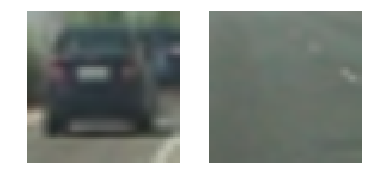

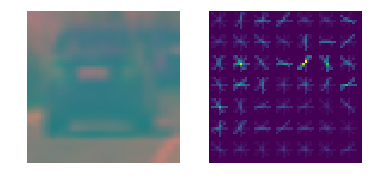

In [33]:
fig = plt.figure()

plt.subplot(121)
car = mpimg.imread(car_list[0])
plt.imshow(car)
plt.axis('off')
plt.subplot(122)
notCar = mpimg.imread(non_car_list[0])
plt.imshow(notCar)
plt.axis('off')


yCrCb_img = cv2.cvtColor(car,cv2.COLOR_RGB2YCrCb)
feature,hog_image = get_hog_features(yCrCb_img[:,:,1],orient =8,pix_per_cell = 9,cells_per_block = 2,vis=True,feature_vec=True)
plt.figure()
plt.subplot(121)
plt.imshow(yCrCb_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(hog_image)
plt.axis('off')

In [22]:
#fit SVM

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn import svm 

y = np.hstack((np.ones(len(car_feature)),np.zeros(len(non_car_feature))))
X = np.vstack((car_feature,non_car_feature)).astype(np.float64)

#normalize features
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)


rand_state = np.random.randint(0,100)
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size=0.2,random_state=rand_state)

svc = LinearSVC()
svc.fit(X_train,y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [23]:
#validate model
print('Test Accuary of svc = ',svc.score(X_test,y_test))

Test Accuary of svc =  0.991025641026


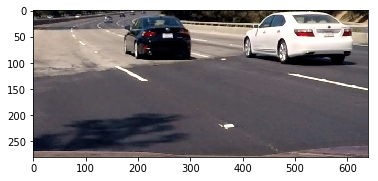

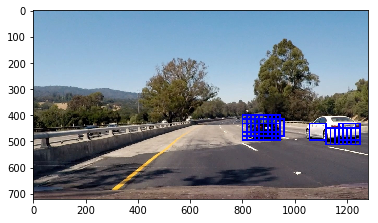

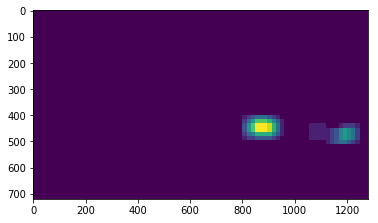

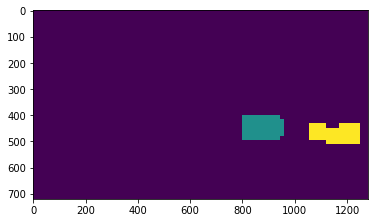

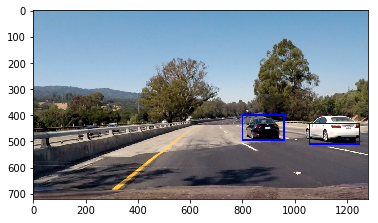

In [90]:
%matplotlib inline
path = glob.glob("./test_images/test4.jpg")

offset = 40
for fileName in path:
    im = mpimg.imread(fileName)
    imshape = im.shape
    y_start_stop=[np.int(imshape[0]/2),imshape[0]]
    x_start_stop=[np.int(imshape[1]/2),imshape[1]]
    bim,windows = find_cars(im, y_start_stop[0] + offset,y_start_stop[1] - offset,x_start_stop[0],x_start_stop[1],1,svc,X_scaler,9,8,2,(32,32),32)
    plt.figure()
    plt.imshow(bim)
    cv2.imwrite('./output/sliding_window.png',cv2.cvtColor(bim,cv2.COLOR_RGB2BGR))
    
    heatMap = np.zeros((imshape[0],imshape[1]))
    heatMap = add_heat(heatMap,windows)
    heatMap = apply_theshold(heatMap, 0)
    heatMap = heatMap 
    labels = label(heatMap)
    
    plt.figure()
    plt.imshow(heatMap)
    heatMap = np.uint8(heatMap * 10)
    heatMap = np.dstack((np.zeros_like(heatMap),heatMap,heatMap))
    cv2.imwrite('./output/bboxes_and_heat.png',cv2.cvtColor(heatMap,cv2.COLOR_RGB2BGR))
   
    plt.figure()
    plt.imshow(labels[0])
    lab = np.uint8(np.dstack((np.zeros_like(labels[0]),labels[0],labels[0])))
    lab = lab * 100
    cv2.imwrite('./output/labels_map.png',cv2.cvtColor(lab,cv2.COLOR_RGB2BGR))
    
    boxIm = draw_labeld_bboxes(im,labels)
    plt.figure()
    plt.imshow(boxIm)
    cv2.imwrite('./output/output_bboxes.png',cv2.cvtColor(bim,cv2.COLOR_RGB2BGR))
    

done


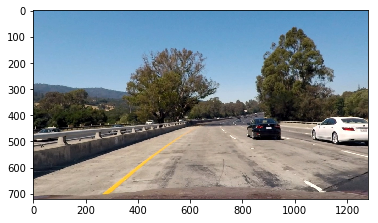

In [25]:
#Camera Calibration

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

#numbers of blocks in chessboard
nx = 9
ny = 6
shape = []
objPoints = [] #3D points in real world space
imgPoints = [] #2D points in image plane
images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    #plt.imshow(img)

    #Populate the object points for the chessboard
    objp = np.zeros((nx * ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    #convert image from RGB to Grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    shape = gray.shape[::-1]
    #Find the chessboard corners in the image
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    #If corners are found, add object points and image points 
    if ret == True:
        imgPoints.append(corners)
        objPoints.append(objp)
    
        img = cv2.drawChessboardCorners(img,(nx,ny),corners, ret)
  

if(len(objPoints) > 0):
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objPoints, imgPoints,shape,None,None)
    img = mpimg.imread('test_images/test1.jpg')
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    #cv2.imwrite('output_images/test1.jpg', cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))
    plt.imshow(dst)
print('done')



In [26]:
#Lane Detetection

class LaneDetection():
    def __init__(self):
        self.firstRun = True
        self.laneWindowDetected  = False
        self.recent_xfitted = []
        self.bestx = None
        self.mean_left_fit = []
        self.mean_right_fit = []
        self.current_fit = [np.array([False])]
        self.radius_of_curvature = None
        self.line_base_ps = None
        self.diffs = np.array([0,0,0],dtype='float')
        self.allx = None
        self.ally = None
        self.left_fit = []
        self.right_fit = []

    
    def weighted_img(self,img, initial_img, a=0.8, b=1., c=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.
        
        `initial_img` should be the image before any processing.
        
        The result image is computed as follows:
        
        initial_img * a + img * b + c
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, a, img, b, c)
    
    def abs_sobel_tresh(self,img,orient = 'x',sobel_kernal=3,mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on sobel operation
        '''
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        if orient =='x':
            abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernal))
        else:
            abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernal))
      
        scaled_sobel = np.uint(255*abs_sobel/np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= mag_tresh[0]) & (scaled_sobel <= mag_tresh[1])] = 1
        return binary_output


    def mag_tresh(self,img,sobel_kernal=3,mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on magnintued of image
        '''
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernal)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernal)
        #abs_sobelx = np.absolute(sobelx)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_tresh[0]) & (gradmag <= mag_tresh[1])] = 1
        return binary_output
    
    def dir_tresh(self,img,sobel_kernal=3,mag_tresh=(0,np.pi/2)):
        '''
        utility function to apply tresholding on input image based on direction of image
        '''
        
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernal)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernal)
        #abs_sobelx = np.absolute(sobelx)
        absgraddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
        binary_output = np.zeros_like(absgraddir)
        binary_output[(absgraddir >= mag_tresh[0]) & (absgraddir <= mag_tresh[1])] = 1
        return binary_output

    def hls_tresh(self,img, layer = 2, mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on hls of image
        '''
            
        hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,layer]
        s_binary = np.zeros_like(s_channel)
        s_binary [(s_channel >= mag_tresh[0]) & (s_channel <= mag_tresh[1])] = 1
        return s_binary
    
    def rgb_tresh(self,img, layer = 1, mag_tresh=(0,255)):
        '''
        utility function to apply tresholding on input image based on rgb of image
        '''
            
        r_channel = img[:,:,layer]
        r_binary = np.zeros_like(r_channel)
        r_binary [(r_channel >= mag_tresh[0]) & (r_channel <= mag_tresh[1])] = 1
        return r_binary
            
    def thresholdImage(self,img):
        '''
        utility function to apply pipeline of thresholdin on input image
        '''
            
        ksize = 3
        thr = (0,255)
        gradx = self.abs_sobel_tresh(img, orient='x',sobel_kernal=ksize ,mag_tresh=(20,100))
        grady = self.abs_sobel_tresh(img, orient='y',sobel_kernal=ksize ,mag_tresh=(20,100))
        mag_binary = self.mag_tresh(img, sobel_kernal=ksize ,mag_tresh=(30,100))
        dir_binary = self.dir_tresh(img, sobel_kernal=ksize ,mag_tresh=(.7,1.3))
        s_binary = self.hls_tresh(img,layer =2 , mag_tresh = (170,255))
        l_binary = self.hls_tresh(img,layer =1 , mag_tresh = (140,255))
        h_binary = self.hls_tresh(img,layer =0 , mag_tresh = (170,255))
        
        r_binary = self.rgb_tresh(img,layer = 0, mag_tresh = (220,255))
        g_binary = self.rgb_tresh(img,layer = 1, mag_tresh = (220,255))
        b_binary = self.rgb_tresh(img,layer = 2, mag_tresh = (220,255))
        
        combined = np.zeros_like(dir_binary,dtype = np.uint8)
        combined[((gradx == 1) & (grady == 1))| ((mag_binary == 1) & (dir_binary == 1)) | ((s_binary == 1) & (l_binary == 1)  ) |((r_binary == 1) & (g_binary ==1)& (b_binary ==1))] = 255
        
        kernel = np.ones((5,5),np.uint8)
        combined = cv2.morphologyEx(combined,cv2.MORPH_CLOSE,kernel,iterations = 2)
        
        kernel = np.ones((3,3),np.uint8)
        #combined = cv2.dilate(combined,kernel,iterations = 2)
        
        return combined 
    

    def warpImage(self,img):
        '''
        Utility function apply persprective transform on image
        '''
        imshape = (img.shape[1],img.shape[0])
        
        src = np.float32([[190, 720],[585, 455],[1130, 720],[705, 455]])
        dst = np.float32([[300, 720],[300, 100],[1000, 720],[1000, 100]])
        
        self.perspective = cv2.getPerspectiveTransform(src,dst)
        self.invPerspective = cv2.getPerspectiveTransform(dst,src)
        warped = cv2.warpPerspective(img, self.perspective, imshape,flags = cv2.INTER_LINEAR)
     
        return warped
    
    def slideWindow(self,warped,in_img,temp):
        '''
        Utility function to apply sliding window algoritham to find lane
        '''
        histogram = np.sum(warped[:600,:],axis=0)# np.sum(warped[:warped.shape[0]//2,:],axis=0)
    
       
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
       
    
        nwindows = 9
        window_height= np.int(warped.shape[0]/nwindows)
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
    
        margin = 100
        minpix = 50
    
        left_lane_inds = []
        right_lane_inds = []
        
        leftx =  []
        lefty = []
        rightx =[]
        righty =[]
    
        out_img = np.dstack((warped,warped,warped))*255
       
        if (self.laneWindowDetected == True): #& (self.laneDetected == True):
            left_lane_inds = ((nonzerox > (self.prev_left_fit[0] *(nonzeroy ** 2) + self.prev_left_fit[1] * nonzeroy + self.prev_left_fit[2] - margin))&
                              (nonzerox < (self.prev_left_fit[0] * (nonzeroy **2)+ self.prev_left_fit[1]*nonzeroy + self.prev_left_fit[2] + margin)))
            
            right_lane_inds = ((nonzerox > (self.prev_right_fit[0] *(nonzeroy ** 2) + self.prev_right_fit[1] * nonzeroy + self.prev_right_fit[2] - margin))&
            (nonzerox < (self.prev_right_fit[0] * (nonzeroy **2)+ self.prev_right_fit[1]*nonzeroy + self.prev_right_fit[2] + margin)))
            flag = 0
        else:
            self.laneWindowDetected = True
        
            for window in range(nwindows):
                win_y_low = warped.shape[0] - (window + 1) * window_height
                win_y_high = warped.shape[0] - window * window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,255),2)
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
                
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & ( nonzerox >= win_xleft_low)& 
                              (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & 
                               (nonzerox < win_xright_high)).nonzero()[0]
            
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
            
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                    
                    leftx.append(leftx_current)
                    lefty.append(np.int(np.mean(nonzeroy[good_left_inds])))
                    
                if len(good_right_inds) > minpix:
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                    
                    rightx.append(rightx_current)
                    righty.append(np.int(np.mean(nonzeroy[good_right_inds])))
        
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            flag = 0
           
        
            
        #'''
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        #'''
        
        ploty = np.linspace(0,warped.shape[0] - 1 ,warped.shape[0])
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700
        
        radCheck = False

        if len(righty) <= 0 or len(lefty)  <= 0:
            self.laneWindowDetected = False
            
            self.left_fit = self.prev_left_fit 
            self.right_fit = self.prev_right_fit
            if 0 == 1:
                plt.figure()
                plt.subplot(3,1,1)
                plt.imshow(temp)
                plt.subplot(3,1,2)
                plt.imshow(out_img)
                plt.subplot(3,1,3)
                plt.plot(histogram)
                #return
        else :
            #self.laneWindowDetected = True
            self.left_fit = np.polyfit(lefty,leftx,2)
            self.right_fit = np.polyfit(righty,rightx,2)
            
            left_fit_cr = np.polyfit(lefty * ym_per_pix,leftx * xm_per_pix,2)
            right_fit_cr = np.polyfit(righty * ym_per_pix,rightx * xm_per_pix,2)
           
            y_eval = 0# np.max(ploty)
            left_curverad = ((1 + ((2 * left_fit_cr[0]*y_eval  * ym_per_pix) + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
            right_curverad = ((1 +((2 * right_fit_cr[0]*y_eval * ym_per_pix) + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
            radCheck= (abs(left_curverad - right_curverad) ) < 500
            
            centerOfRoad = abs(left_curverad - right_curverad) / 2
            cameraPos = in_img.shape[1] / 2
            carOffsetFromCenter = (cameraPos - centerOfRoad) * xm_per_pix
            #print(carOffsetFromCenter)
           #print(left_curverad ,right_curverad )
        '''
        
        self.left_fit_cr = np.polyfit(lefty * ym_per_pix,leftx * xm_per_pix,2)
        self.right_fit_cr = np.polyfit(righty * ym_per_pix,rightx * xm_per_pix,2)
        
        left_fitx = (self.left_fit[0] * (ploty**2)) + self.left_fit[1] * ploty + self.left_fit[2]
        right_fitx = (self.right_fit[0] * (ploty ** 2)) + self.right_fit[1] * ploty + self.right_fit[2]
        
        y_eval =  np.max(ploty)
        left_curverad = ((1 + ((2 * self.left_fit_cr[0]*y_eval  * ym_per_pix) + self.left_fit_cr[1])**2)**1.5) / np.absolute(2 * self.left_fit_cr[0])
        right_curverad = ((1 +((2 * self.right_fit_cr[0]*y_eval * ym_per_pix) + self.right_fit_cr[1])**2)**1.5) / np.absolute(2 * self.right_fit_cr[0])
        #print(left_curverad / right_curverad ,right_curverad/ left_curverad )
       ''' 
        
      
        
        #distCh = sum((right_fitx - left_fitx)/warped.shape[0]) 
        #distCheck = (distCh > 690) & (distCh < 750) 

        if (self.firstRun == True) | (radCheck ):
                self.firstRun = False
                self.cur_left_fit = self.left_fit
                self.cur_right_fit = self.right_fit
                
                self.prev_left_fit = self.left_fit#(self.best_left_fit + self.left_fit) / 2
                self.prev_right_fit= self.right_fit#(self.best_right_fit + self.right_fit) / 2
        else:
                self.cur_left_fit = self.prev_left_fit
                self.cur_right_fit = self.prev_right_fit
        ''' 
        elif(sanityCheck > 650) | (sanityCheck  <750) :
                self.best_left_fit = (self.best_left_fit + self.left_fit) / 2
                self.best_right_fit= (self.best_right_fit + self.right_fit) / 2
        '''
        
        #self.best_left_fit = self.left_fit#(self.best_left_fit + self.left_fit) / 2
        #self.best_right_fit= self.right_fit#(self.best_right_fit + self.right_fit) / 2
        
        left_fitx = (self.cur_left_fit[0] * (ploty**2)) + self.cur_left_fit[1] * ploty + self.cur_left_fit[2]
        right_fitx = (self.cur_right_fit[0] * (ploty ** 2)) + self.cur_right_fit[1] * ploty + self.cur_right_fit[2]
      
                    
       
     
        #for debug
        if 0== 1:
            
            window_img = np.zeros_like(out_img)
            out_img[nonzeroy[left_lane_inds],nonzerox[left_lane_inds]] = [255,0,0]
            out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [0,0,255]
            
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin,ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
            left_line_pts = np.hstack((left_line_window1,left_line_window2))
            
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin,ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
            right_line_pts = np.hstack((right_line_window1,right_line_window2))
            
            cv2.fillPoly(window_img,np.int_([left_line_pts]),(0,255,0))
            cv2.fillPoly(window_img,np.int_([right_line_pts]),(0,255,0))
            result0 = cv2.addWeighted(out_img,1,window_img,0.3,0)
            plt.figure();
            #plt.subplot(2,1,2)
            plt.imshow(result0)
            plt.plot(left_fitx,ploty,color='green',linewidth = 3)
            plt.plot(right_fitx,ploty,color='green',linewidth = 3)
            
        ##
        pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        pts = np.hstack((pts_left, pts_right))
        warp_zero= np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
        cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))
        
        invWarp = cv2.warpPerspective(color_warp,self.invPerspective,(warped.shape[1],warped.shape[0]))
        result = self.weighted_img(invWarp,in_img,1.0,0.3,0)
        #print(lPoints)
        #cv2.drawContours(out_img,lPoints,-1,(255,255,255),thickness = 80)
      
        return result
    
        
    def processImage(self,image):
        self.img = image
        self.undistImg = cv2.undistort(image,mtx,dist,None,mtx)
        #linesDetected,combinedImage, srcPts, dstPts = self.detectLaneLines(image);
        warped = self.warpImage(self.undistImg)
        combinedImage = self.thresholdImage(warped)
        #vertices = np.array([[(0, imshape[0]),(imshape[1],imshape[0]),(imshape[1]/2, imshape[1]/3 - 1) ]], dtype=np.int32)
        #dst = np.array([[(200, 720),(200, 0),(1200, 0),(1200, 720)]])
        #combinedImage = self.region_of_interest(combinedImage,  dst )
        #temp =  np.dstack((warped,warped,warped))
        slided = self.slideWindow(combinedImage,image,combinedImage)
        return slided

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:25<00:00,  1.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

Wall time: 13min 26s


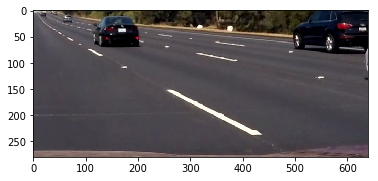

In [27]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output/project_video.mp4'


def processImage(im):
      
    boxIm,windows = find_cars(im, y_start_stop[0] + offset,y_start_stop[1] - offset,x_start_stop[0],x_start_stop[1],1,svc,X_scaler,9,8,2,(32,32),32)
    laneDetect = LaneDetection()
    
 
    heatMap = np.zeros((imshape[0],imshape[1]))
    heatMap = add_heat(heatMap,windows)
    heatMap = apply_theshold(heatMap, 0)
    heatMap = heatMap 
    labels = label(heatMap)
    
    laneDetcted = laneDetect.processImage(im)
    processed = draw_labeld_bboxes(laneDetcted,labels)
    return processed
    
clip2 = VideoFileClip('project_video.mp4')
_clip = clip2.fl_image(processImage)
%time _clip.write_videofile(output, audio=False)

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))